In [1]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
from quaternion import Quaternion

data_num = 1
imu = io.loadmat('imu/imuRaw' + str(data_num) + '.mat')
accel = imu['vals'][0:3,:].astype(float)
gyro = imu['vals'][3:6,:].astype(float)
time_series = imu['ts'][0:].astype(float).T
T = np.shape(imu['ts'])[1]

delta_t = np.mean(np.diff(time_series))

g = 9.81

C:\Users\Chandravaran K V\Anaconda3\envs\open3d\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\Chandravaran K V\Anaconda3\envs\open3d\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Chandravaran K V\Anaconda3\envs\open3d\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [16]:
vicon = io.loadmat('vicon/viconRot' + str(data_num) + '.mat')
rotation_vicon = vicon['rots'].astype(float)
time_series_vicon = vicon['ts'][0,:]
time_series_vicon = time_series_vicon.astype(float).T
T_vicon  = np.shape(vicon['ts'])[1]

In [17]:
delta_t = np.mean(np.diff(time_series))
delta_t_vicon = np.mean(np.diff(time_series_vicon))

In [45]:
# Function to preprocess accelerometer readings
def preprocess_accel(accel_in):
    accel_processed = np.zeros_like(accel_in)
    accel_processed[0,:] = -accel_in[0,:]
    accel_processed[1,:] = -accel_in[1,:]
    accel_processed[2,:] = accel_in[2,:] 
    return accel_processed

# Function to preprocess gyro readings
def preprocess_gyro(gyro_in):
    gyro_processed = np.zeros_like(gyro_in)
    gyro_processed[2,:] = gyro_in[0,:]
    gyro_processed[1,:] = gyro_in[1,:]
    gyro_processed[0,:] = gyro_in[2,:] 
    return gyro_processed

# Function to convert rotation matrix to heading vector
def rot_to_heading(rot,T):
    heading = np.array([0,0,g])
    ori_vicon = np.zeros((3,T))
    ori_vicon = np.matmul(rot.T,heading).T # why
    return ori_vicon

# function to convert raw readings to SI units
def convert_to_SI(data, beta, alpha):
    return (data - beta) * 3300.0/(1023.0*alpha)

# Function to compute the derivative from viceon data
def compute_derivative(T_vicon, rotation_vicon):
    #first convert to quaternion
    q_vicon = []
    q_temp = Quaternion()
    q_temp.from_rotm(rotation_vicon[:,:,0])
    q_vicon.append(q_temp)
    omegas = np.zeros((3,T_vicon))
    for i in range(1, T_vicon):
        q = Quaternion()
        q.from_rotm(rotation_vicon[:,:,i])
        q_vicon.append(q)
        temp = q_vicon[i-1].inv() * q_vicon[i] 
        omegas[:,i] = temp.axis_angle(dt=delta_t_vicon)
    
    return omegas
        

In [46]:
accel_processed = preprocess_accel(accel)
gyro_processed = preprocess_gyro(gyro)

vicon_data = rot_to_heading(rotation_vicon,T)



alphas_accel = np.array([[34.5826],
        [34.2690],
        [34.4407]])
betas_accel = np.array([[-511.2068],
        [-500.470],
        [ 500.8867]])

alphas_gyro = np.array([[249.9296],
        [250.0695],
        [250.0364]])
betas_gyro = np.array([[374.5049],
        [375.2100],
        [373.0922]])

accel_converted = convert_to_SI(accel_processed, betas_accel, alphas_accel)
gyro_converted = convert_to_SI(gyro_processed, betas_gyro, alphas_gyro)

Text(0, 0.5, 'Acceleration (m/s^2) ->')

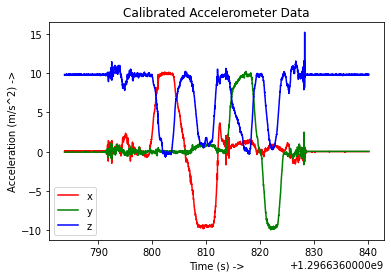

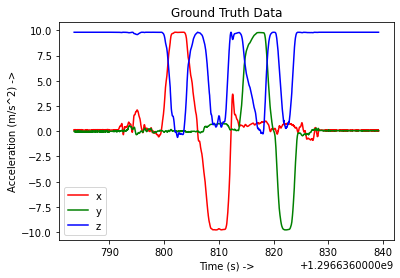

In [47]:

# Ploting accelerometer data
plt.figure()
plt.plot(time_series, accel_converted[0,:], label="x", color="red")
plt.plot(time_series, accel_converted[1,:], label="y", color="green")
plt.plot(time_series, accel_converted[2,:], label="z", color="blue")
plt.legend()
plt.title("Calibrated Accelerometer Data")
plt.xlabel("Time (s) ->")
plt.ylabel("Acceleration (m/s^2) ->")

# Ploting gyroscope data
plt.figure()
plt.plot(time_series_vicon, vicon_data[0,:], label="x", color="red")
plt.plot(time_series_vicon, vicon_data[1,:], label="y", color="green")
plt.plot(time_series_vicon, vicon_data[2,:], label="z", color="blue")
plt.legend()
plt.title("Ground Truth Data")
plt.xlabel("Time (s) ->")
plt.ylabel("Acceleration (m/s^2) ->")

In [48]:
omega_vicon = compute_derivative(T_vicon, rotation_vicon)

Text(0, 0.5, 'Omega (rad/s)')

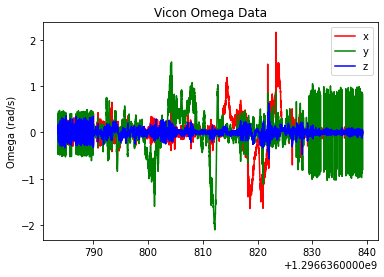

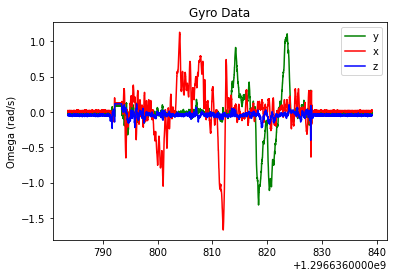

In [51]:
#plot out vicon omega data
plt.figure()
plt.plot(time_series_vicon, omega_vicon[0,:], label="x", color="red")
plt.plot(time_series_vicon, omega_vicon[1,:], label="y", color="green")
plt.plot(time_series_vicon, omega_vicon[2,:], label="z", color="blue")
plt.legend()
plt.title("Vicon Omega Data")
plt.ylabel("Omega (rad/s)")
# plot out gyro data

plt.figure()
plt.plot(time_series_vicon[:T_vicon], gyro_converted[1,:T_vicon], label="y", color="green")
plt.plot(time_series_vicon[:T_vicon], gyro_converted[0,:T_vicon], label="x", color="red")
plt.plot(time_series_vicon[:T_vicon], gyro_converted[2,:T_vicon], label="z", color="blue")
plt.legend()
plt.title("Gyro Data")
plt.ylabel("Omega (rad/s)")

In [7]:
x =np.array([1,2,3])
print(x.shape)
noise = np.random.normal(0, 0.1, x.shape)
output = x + noise
print(output)

(3,)
[1.00410473 2.0497031  3.05590066]


In [8]:
print(noise)

[0.00410473 0.0497031  0.05590066]


In [4]:
from filter import UncentedKalmanFilter

In [ ]:
Q = np.diag([0.1, 0.1, 0.1])
R = np.diag([0.1, 0.1, 0.1, 0.1, 0.1, 0.1])


